### Main Config

In [1]:
Data_path = "/content/drive/MyDrive/Behavioral/Data"
Models_path = "/content/drive/MyDrive/Behavioral/Models"

### Google Colab Configs

In [ ]:
%%capture
!pip uninstall -y pandas numpy scipy
!pip install pandas scipy==1.10.1

In [38]:
# Colab Config

%%capture
!pip install emoji
!pip install langdetect
!pip install nltk
!pip install tqdm
!pip install langid
!pip install scipy==1.10.1
!pip install genism
!pip install pyLDAvis

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Project

In [4]:
random_seed = 42
notebook_env = "test" # "test" for experimenting, "final" for final execution

In [5]:
import kagglehub
import os
import json
import pandas as pd
import spacy
import emoji
import re
from langdetect import detect, detect_langs
import nltk
import string
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm
import langid
from ast import pattern
tqdm.pandas()

In [6]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Download Data from Kaggle/Load Data

In [10]:
dataset_name = "10Mar2025.json"
dataset_path = os.path.join(Data_path, dataset_name)

if os.path.isfile(dataset_path):
  with open(dataset_path, 'r') as f:
    data = json.load(f)
  print("Dataset loaded from drive.")
else:
  fort_list_path = kagglehub.dataset_download("jeannicolasduval/2024-fortune-1000-companies")
  print("Dataset downloaded from kaggle.")

  # Load the wanted file
  temp_path = os.path.join(fort_list_path, "10Mar2025.json")
  data = pd.read_json(temp_path)

  # Save the data into drive
  data.to_json(dataset_path)
  print("Dataset saved to drive.")

  # The complementary Dataset
dataset_name = "fortune1000_2024.csv.csv"
dataset_path = os.path.join(Data_path, dataset_name)

if os.path.isfile(dataset_path):
  fortune_company_list = pd.read_csv(dataset_path)
  print("Dataset loaded from drive.")
else:
  fort_list_path = kagglehub.dataset_download("jeannicolasduval/2024-fortune-1000-companies")
  print("Dataset downloaded from kaggle.")
  fortune_company_list = pd.read_csv(os.path.join(fort_list_path, "fortune1000_2024.csv"))
  fortune_company_list.to_csv(dataset_path)
  print("Dataset saved to drive.")

Dataset loaded from drive.


In [11]:
fortune_company_list.head()

,Unnamed: 0,Rank,Company,Ticker,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs,...,Assets_M,CEO,Country,HeadquartersCity,HeadquartersState,Website,CompanyType,Footnote,MarketCap_Updated_M,Updated
0,0,1,Walmart,WMT,Retailing,General Merchandisers,yes,no,no,no,...,252399.0,C. Douglas McMillon,U.S.,Bentonville,Arkansas,https://www.stock.walmart.com,Public,"Figures are for fiscal year ended Jan. 31, 202...",559911.0,2024-08-05
1,1,2,Amazon,AMZN,Retailing,Internet Services and Retailing,yes,no,no,no,...,527854.0,Andrew R. Jassy,U.S.,Seattle,Washington,https://www.amazon.com,Public,"Market value as of July 15, 2024.",2005565.0,2024-08-05
2,2,3,Apple,AAPL,Technology,"Computers, Office Equipment",yes,no,no,no,...,352583.0,Timothy D. Cook,U.S.,Cupertino,California,https://www.apple.com,Public,"Figures are for fiscal year ended Sept. 30, 20...",3594309.0,2024-08-05
3,3,4,UnitedHealth Group,UNH,Health Care,Health Care: Insurance and Managed Care,yes,no,no,yes,...,273720.0,Andrew P. Witty,U.S.,Minnetonka,Minnesota,https://www.unitedhealthgroup.com,Public,"Market value as of July 15, 2024.",474339.0,2024-08-05
4,4,5,Berkshire Hathaway,BRKA,Financials,Insurance: Property and Casualty (Stock),yes,no,no,yes,...,1069978.0,Warren E. Buffett,U.S.,Omaha,Nebraska,https://www.berkshirehathaway.com,Public,"Market value as of July 15, 2024.",937028.0,2024-08-05


In [12]:
data[0].keys()

dict_keys(['company', 'rank', 'timestamp', 'tweets', 'posts', 'comments', 'metadata'])

In [13]:
columns = ["Company", "Text", "Source"]
atts_temp = ["tweets", "comments", "posts"]
source_dic = {"tweets": "Twitter", "comments": "Reddit-Comments", "posts": "Reddit-Posts"}
mp_doc_list = []

for company in data:
  for text_list in atts_temp:
    if text_list in company:
      for text in company[text_list]:
        mp_doc_list.append([company["company"], text["text"], source_dic[text_list]])


data_df = pd.DataFrame(mp_doc_list, columns=columns)
data_df

,Company,Text,Source
0,Walmart,$GOOGL $GOOG $WMT Google And Walmart Payment A...,Twitter
1,Walmart,Can $PHNIX become the first meme coin to dethr...,Twitter
2,Walmart,"Walmart $WMT \n\nThe Laughing Cow Cheese, 32 p...",Twitter
3,Walmart,Some of the most iconic businesses ever \n\n1....,Twitter
4,Walmart,Walmart $WMT currently has 1.05 Billion Square...,Twitter
...,...,...,...
591342,Clear Channel Outdoor Hldgs.,Hi BUB Sub!\n\n\nHad this account on the back ...,Reddit-Posts
591343,Clear Channel Outdoor Hldgs.,I am curious how these events typically play o...,Reddit-Posts
591344,Clear Channel Outdoor Hldgs.,,Reddit-Posts
591345,Clear Channel Outdoor Hldgs.,The Role of the National Weather Service in Em...,Reddit-Posts


In [14]:
enriched_data = pd.merge(fortune_company_list[["Company", "Ticker", "Sector", "Industry"]], data_df, left_on="Company", right_on="Company")
enriched_data.sample(10, random_state=random_seed)

,Company,Ticker,Sector,Industry,Text,Source
233120,BlackRock,BLK,Financials,Securities,You do understand that BlackRock buys the shar...,Reddit-Comments
420124,Hubbell,HUBB,Industrials,"Electronics, Electrical Equip.",,Reddit-Posts
221548,Adobe,ADBE,Technology,Computer Software,Your post is about Monkrus.\n\nMonkrus has no ...,Reddit-Comments
169118,Cummins,CMI,Industrials,Industrial Machinery,Hayden\n\nLanger\n\nPonting\n\nSmith\n\nClarke...,Reddit-Comments
88967,RTX,RTX,Aerospace & Defense,Aerospace & Defense,"You posted wrong links for stuff, double check...",Reddit-Comments
99040,HCA Healthcare,HCA,Health Care,Health Care: Medical Facilities,I work at an HCA hospital. We're a private EM ...,Reddit-Comments
469693,Splunk,NaN,Technology,Computer Software,"Over the past year, my org has moved from Splu...",Reddit-Posts
419354,Mattel,MAT,Household Products,"Toys, Sporting Goods",As Title!🙏\n\nPls genuine answer dena !!\n,Reddit-Posts
85860,Boeing,BA,Aerospace & Defense,Aerospace & Defense,These 757 planes and engines are all really ol...,Reddit-Comments
114387,Allstate,ALL,Financials,Insurance: Property and Casualty (Stock),The problem is exactly the people who consider...,Reddit-Comments


In [ ]:
# compare unique companies in the enriched dataset and main dataset
enriched_companies = enriched_data["Company"].unique()
main_companies = data_df["Company"].unique()

print(f"Number of companies in the enriched dataset: {len(enriched_companies)}")
print(f"Number of companies in the main dataset: {len(main_companies)}")

Number of companies in the enriched dataset: 953
Number of companies in the main dataset: 953


In [ ]:
data_df = enriched_data

In [ ]:
# enriched_data_name = "enriched_companyData_complete.csv"
# enriched_data_path = os.path.join(Data_path, enriched_data_name)
# enriched_data.to_csv(os.path.join(Data_path, "enriched_companyData_complete.csv"))

## Preprocessing the texts

In [ ]:
data_df.describe()

,Company,Ticker,Sector,Industry,Text,Source
count,591347,579881,591347,591347,591347,591347
unique,953,932,21,75,487445,3
top,Tesla,TSLA,Technology,Internet Services and Retailing,,Reddit-Posts
freq,9438,9438,132908,60577,82315,329493


In [ ]:
# show duplicates
data_df[data_df.duplicated()].sample(10)

,Company,Ticker,Sector,Industry,Text,Source
547301,NeueHealth,NEUE,Health Care,Health Care: Insurance and Managed Care,,Reddit-Posts
23996,Alphabet,GOOGL,Technology,Internet Services and Retailing,"\n\n\nEnter $GOOG, the conceptual cryptocurren...",Reddit-Posts
4037,Walmart,WMT,Retailing,General Merchandisers,,Reddit-Posts
508008,Roku,ROKU,Media,Entertainment,Does anyone know of a permanent fix for the wo...,Reddit-Posts
532762,Kirby,KEX,Transportation,Shipping,,Reddit-Posts
448350,Snap,SNAP,Technology,Internet Services and Retailing,,Reddit-Posts
314813,Ebay,EBAY,Technology,Internet Services and Retailing,,Reddit-Posts
589526,Dropbox,DBX,Technology,Computer Software,,Reddit-Posts
276138,Dick's Sporting Goods,DKS,Retailing,Specialty Retailers: Other,,Reddit-Posts
466293,Brown & Brown,BRO,Financials,Insurance: Property and Casualty (Stock),,Reddit-Posts


In [17]:
dataset_name = "complete_preprocessed_companyData.csv"
dataset_path = os.path.join(Data_path, dataset_name)

if os.path.isfile(dataset_path):
  temp_df = pd.read_csv(dataset_path)
  print("Dataset loaded from drive.")
else:
  # drop duplicates
  data_df = data_df.drop_duplicates()
  data_df.describe()


  ### Sample for Analysis
  # **Sampling of Enriched Data**: This is done to make experiments lighter, for final analysis all data will be used.
  if notebook_env == "test":
    sample_data_df = data_df.sample(50000, random_state=random_seed)
  elif notebook_env == "final":
    sample_data_df = data_df.copy()

  def preprocess_text(text, index, targets):

    # First Demojize Text
    edited_text = emoji.replace_emoji(text, '')

    # Mask company
    try:
      pattern = r'(?<![a-zA-Z])(?:' + '|'.join(re.escape(word) for word in targets if isinstance(word, str)) + r')(?![a-zA-Z])'
      if re.search(pattern, text, flags=re.IGNORECASE):
          edited_text = re.sub(pattern, "TargetedCompany", text, flags=re.IGNORECASE)
      else:
          edited_text = ""

    except Exception as e:
      raise

    # lower case
    edited_text = edited_text.lower()

    # remove links, mentions, hashtags
    edited_text = re.sub(r"http\S+|www\S+|@\w+|#\w+", '', edited_text)

    # Remove numbers
    edited_text = re.sub(r'\d+', '', edited_text)

    # Remove non ASCII
    edited_text = re.sub(r'[^\x00-\x7F]+', '', edited_text)

    # remove extra spaces
    edited_text = re.sub(r'\s+', ' ', edited_text).strip()

    # return if text is empty
    if edited_text == "":
      return edited_text

    # Remove non english
    try:
      # lang = detect(edited_text)
      lang, _ = langid.classify(edited_text)
      if lang != "en":
          edited_text = ""
    except Exception as e:
      # print(f"Error detecting language for text at index {index} and content:{edited_text}: {e}")
      edited_text = ""

    return edited_text

  temp_df = sample_data_df.copy()
  temp_df["Text"] = temp_df.progress_apply(lambda row: preprocess_text(row["Text"], row.name, [row["Company"], row["Ticker"]]), axis=1)
  temp_df

  temp_df = temp_df[temp_df["Text"] != ""]
  temp_df.describe()

  temp_df.to_csv(dataset_path)


Dataset loaded from drive.


In [18]:
temp_df.head()

,Unnamed: 0,Company,Ticker,Sector,Industry,Text,Source
0,52944,Comcast,CMCSA,Telecommunications,Telecommunications,same thing happened to me this week. police de...,Reddit-Comments
1,143656,Dow,DOW,Chemicals,Chemicals,> stock futures tumbled sunday night to kick o...,Reddit-Posts
2,525390,Sinclair,SBGI,Media,Entertainment,"got some big names in the mid and fwd, feel my...",Reddit-Posts
3,374514,Olin,OLN,Chemicals,Chemicals,not full true! i was playing with targetedcomp...,Reddit-Comments
4,178759,3M,MMM,Chemicals,Chemicals,this storm had to be some kind of divine punis...,Reddit-Posts


## Vectorization and Lemmatization

In [28]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
target_filter = "targetedcompany"

def tokenize_text(text):

  # first remove punct
  no_punct = [char for char in text if char not in string.punctuation]
  no_punct = "".join(no_punct)

  # replace ’ with '
  no_punct = no_punct.replace("’", "'")

  # Lemmatize
  doc = no_punct.split()

  tokens = []
  for token in doc:
    lemmed = lemmatizer.lemmatize(token)
    if lemmed not in stop_words and lemmed != target_filter:
      tokens.append(lemmed)

  return tokens

In [104]:
tokenized_texts = temp_df.progress_apply(lambda row: tokenize_text(row["Text"]), axis=1)

100%|██████████| 35192/35192 [00:29<00:00, 1188.43it/s]


In [105]:
tokenized_texts

,0
0,"[thing, happened, week, police, dept, said, ca..."
1,"[stock, future, tumbled, sunday, night, kick, ..."
2,"[got, big, name, mid, fwd, feel, defence, ligh..."
3,"[full, true, wa, playing, earlier, wa, holding..."
4,"[storm, kind, divine, punishment, cosmic, god,..."
...,...
35187,"[gpa, fine, adequate, anywhere, sat, lower, en..."
35188,"[anyone, else, besides, sick, tired, talk, lik..."
35189,"[hello, rtrains, im, painting, th, anniversary..."
35190,"[backline, control, hero, red, team, available..."


In [31]:
vectorizer = CountVectorizer(analyzer=tokenize_text, min_df=0.005, max_df=0.995)
bow = vectorizer.fit_transform(temp_df["Text"])

In [103]:
print(bow[0])

  (0, 216)	1
  (0, 289)	1
  (0, 717)	1
  (0, 1068)	1
  (0, 1188)	1
  (0, 1381)	1
  (0, 1460)	1
  (0, 1636)	1
  (0, 1781)	1


In [32]:
len(vectorizer.vocabulary_)

1847

In [33]:
print(f"Shape of the BOW: {bow.shape}")
print(f"Number of non-zero values: {bow.nnz}")

Shape of the BOW: (35192, 1847)
Number of non-zero values: 1142541


In [34]:
tf_idf = TfidfTransformer()

In [35]:
tf_idf_text = tf_idf.fit_transform(bow)

In [36]:
tf_idf_text.shape

(35192, 1847)

## Topic Modeling The texts
Initially, we need to understand what sort of content we have. This will help deciding if we should go with data based topics or anchored topics.

In [115]:
%%capture
!pip install pyLDAvis==3.4.1
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
!pip install gensim==4.3.2
!pip install scipy --upgrade

In [ ]:
from gensim.models import CoherenceModel, LdaModel, HdpModel
from gensim.corpora import Dictionary, BleiCorpus

from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [106]:
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [122]:
topic_counts = [2,4,6,8,10,15,25,50]

In [126]:
models = []
coherence_values = []

for i in tqdm(topic_counts):
  lda_model = LdaModel(
      corpus=corpus,
      id2word=dictionary,
      num_topics=i,
      random_state=random_seed,
      passes=10,
      iterations=100
  )

  models.append(lda_model)
  cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
  coherence_values.append(cm.get_coherence())

100%|██████████| 8/8 [35:39<00:00, 267.49s/it]


In [137]:
c_v_coherence = []

for model in models:
  cm = CoherenceModel(model=model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
  c_v_coherence.append(cm.get_coherence())

Text(0.5, 1.0, 'C_V Coherence Score vs. Number of Topics')

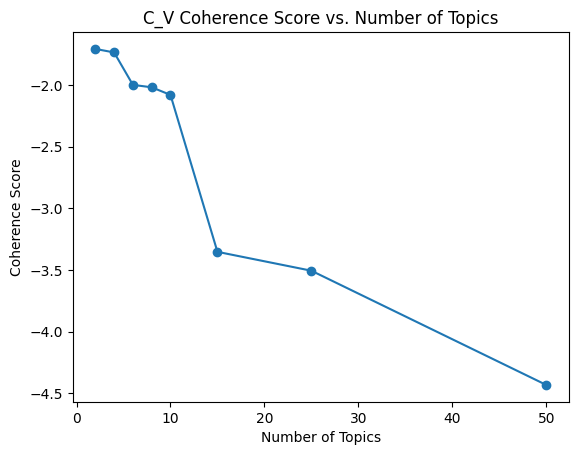

In [138]:
# plot coherence by the topic count
import matplotlib.pyplot as plt

plt.plot(topic_counts, coherence_values, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('C_V Coherence Score vs. Number of Topics')

Text(0.5, 1.0, 'Coherence Score vs. Number of Topics')

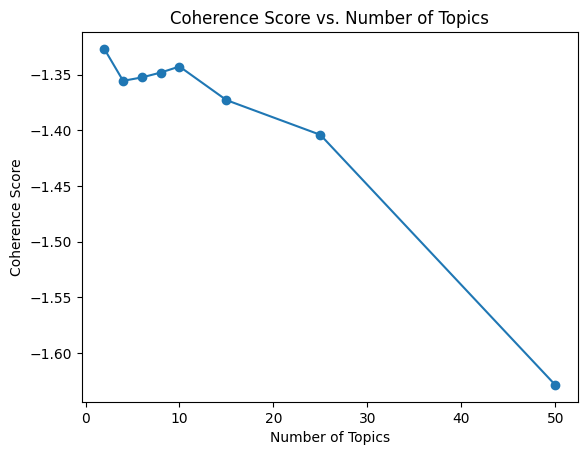

In [125]:
# plot coherence by the topic count
import matplotlib.pyplot as plt

plt.plot(topic_counts, coherence_values, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')

In [127]:
# for idx, model in enumerate(models):
#   model_name = "GensimLdaModel_TopicCount" + str(topic_counts[idx])
#   model_path = os.path.join(Models_path, model_name)
#   model.save(model_path)

In [128]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(models[4], corpus, dictionary, mds="mmds", R=30)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.251056 -0.208792       1        1  25.411987
1     -0.162437 -0.165657       2        1  17.926465
7     -0.025456  0.207084       3        1  10.932983
0     -0.025347 -0.362275       4        1   9.913086
3     -0.264009  0.037874       5        1   9.092961
9      0.137456  0.334232       6        1   7.058157
5      0.244909 -0.278768       7        1   6.574983
8     -0.272363  0.293906       8        1   4.969242
2      0.217211  0.083519       9        1   4.761701
6      0.401092  0.058877      10        1   3.358434, topic_info=           Term          Freq         Total Category  logprob  loglift
64           wa  29632.000000  29632.000000  Default  30.0000  30.0000
308          im  16308.000000  16308.000000  Default  29.0000  29.0000
2099     market   4986.000000   4986.000000  Default  28.0000  28.0000
765     company   4883.000000   4883.000000  Default  27.0000  27.0000
197        dont  10014.000000  10014.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
857   available    413.303114   1661.666213  Topic10  -5.3442   2.0023
96         also    525.110415   9136.828680  Topic10  -5.1048   0.5372
2423     others    404.047004   1727.168948  Topic10  -5.3669   1.9410
2071   location    378.318057   1102.769742  Topic10  -5.4327   2.3239
2992    contact    379.570340   1430.757205  Topic10  -5.4294   2.0668

[743 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
19720      2  0.985824  acceptable
1111       1  0.119951     account
1111       2  0.001475     account
1111       3  0.034412     account
1111       6  0.140107     account
...      ...       ...         ...
617        3  0.151802       youre
617        4  0.143967       youre
617        7  0.000326       youre
9719       9  0.994594         yoy
1368       1  0.993572          yr

[1860 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 8, 1, 4, 10, 6, 9, 3, 7])

In [129]:
lda_model = LdaModel(
      corpus=corpus,
      id2word=dictionary,
      num_topics=5,
      random_state=random_seed,
      passes=10,
      iterations=100
  )

In [130]:
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-1.98819942508226

In [131]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds="mmds", R=30)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.083159  0.254806       1        1  41.122639
1     -0.119870  0.083361       2        1  25.011465
2     -0.231175 -0.187119       3        1  15.438340
3      0.136970 -0.235810       4        1  10.405512
4      0.297233  0.084761       5        1   8.022044, topic_info=         Term          Freq         Total Category  logprob  loglift
64         wa  28196.000000  28196.000000  Default  30.0000  30.0000
2099   market   5003.000000   5003.000000  Default  29.0000  29.0000
83       game   4263.000000   4263.000000  Default  28.0000  28.0000
308        im  15576.000000  15576.000000  Default  27.0000  27.0000
765   company   4805.000000   4805.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
2046    white    376.863610   1079.366786   Topic5  -6.3072   1.4707
2690     case    404.082140   2210.066114   Topic5  -6.2375   0.8238
1056     area    384.304159   1457.498073   Topic5  -6.2877   1.1899
1924   review    371.235813   1155.013108   Topic5  -6.3223   1.3879
125      best    374.029063   3168.665315   Topic5  -6.3148   0.3862

[400 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1111      1  0.002536  account
1111      2  0.984974  account
1111      3  0.012173  account
5118      2  0.995259    admin
1508      2  0.114825       ai
...     ...       ...      ...
616       1  0.264979      yes
616       2  0.239615      yes
616       4  0.009714      yes
616       5  0.485166      yes
4071      5  0.996930     yung

[793 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [ ]:
# Map topic index to a descriptive title
topic_titles = {
    0: "Casual Online Chatter",
    1: "Book or Media Reviews",
    2: "Consumer Goods / Retail",
    3: "Finance & Business News",
    4: "Job Applications & Recruitment",
    5: "Tech Support & Software Use"
}


In [ ]:
import matplotlib.pyplot as plt

# Count topics
topic_counts = temp_df["Topic"].value_counts().sort_index()

# Map the index to topic titles for labeling
labels = [topic_titles[i] for i in topic_counts.index]

# Plot with titles as x-axis labels
plt.figure(figsize=(10, 6))
plt.bar(labels, topic_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title("Document Counts per Topic")
plt.ylabel("Number of Documents")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Group data by sector and topic, and count occurrences
sector_topic_counts = temp_df.groupby(['Sector', 'Topic'])['Topic'].count().unstack()

# Get sector and topic labels
sectors = sector_topic_counts.index
topic_labels = [topic_titles[i] for i in range(lda.n_components)]

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each topic within each sector
bottom = [0] * len(sectors)  # Initialize bottom for stacking
for i, topic_label in enumerate(topic_labels):
    ax.bar(sectors, sector_topic_counts[i], label=topic_label, bottom=bottom)
    bottom = [bottom[j] + sector_topic_counts[i][j] for j in range(len(sectors))]

# Set chart labels and formatting
ax.set_xlabel("Sector")
ax.set_ylabel("Number of Documents")
ax.set_title("Topic Distribution Across Sectors")
ax.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named 'temp_df' and contains 'Source' and 'Topic' columns

# Group data by source and topic, and count occurrences
source_topic_counts = temp_df.groupby(['Source', 'Topic'])['Topic'].count().unstack()

# Get source and topic labels
sources = source_topic_counts.index
topic_labels = [topic_titles[i] for i in range(lda.n_components)]  # Assuming you have topic_titles defined

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each topic within each source
bottom = [0] * len(sources)  # Initialize bottom for stacking
for i, topic_label in enumerate(topic_labels):
    ax.bar(sources, source_topic_counts[i], label=topic_label, bottom=bottom)
    bottom = [bottom[j] + source_topic_counts[i][j] for j in range(len(sources))]

# Set chart labels and formatting
ax.set_xlabel("Source")
ax.set_ylabel("Number of Documents")
ax.set_title("Topic Distribution Across Sources")
ax.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a dictionary to store the word clouds for each topic
topic_wordclouds = {}

# Iterate through each topic
for topic_index in range(lda.n_components):
    # Get documents belonging to the current topic
    topic_documents = temp_df[temp_df["Topic"] == topic_index]["Text"]

    # Create a frequency dictionary for words in the topic documents
    word_frequencies = {}
    for doc in topic_documents:
        for word in tokenize_text(doc):  # Use your tokenize_text function
            if word in feature_names:
                word_frequencies[word] = word_frequencies.get(word, 0) + 1

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_frequencies)

    # Store the word cloud in the dictionary
    topic_wordclouds[topic_index] = wordcloud

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_index}: {topic_titles[topic_index]}")  # Assuming you have topic_titles
    plt.show()


## Test extract ADJ

Text is there now, we need to extract the dimensions for each of the companies.

In [ ]:
dimensions = ["Effectiveness", "Innovation", "Ethics", "Empathy", "Aesthetic"]

In [ ]:
import spacy
from sentence_transformers import SentenceTransformer, util
from collections import defaultdict
import torch

# Load models
nlp = spacy.load("en_core_web_sm")
model = SentenceTransformer("all-MiniLM-L6-v2")

# Define your semantic dimensions with positive/negative poles
dimensions = {
    "effectiveness": ("efficient", "inefficient"),
    "innovation": ("innovative", "outdated"),
    "trust": ("honest", "manipulative"),
    "empathy": ("caring", "cold"),
    "aesthetic": ("sleek", "ugly")
}

# Pre-encode the pole vectors for speed
anchor_vectors = {
    dim: {
        "pos": model.encode(pos, convert_to_tensor=True),
        "neg": model.encode(neg, convert_to_tensor=True)
    }
    for dim, (pos, neg) in dimensions.items()
}

In [ ]:
def score_adjective_on_dimensions(adj):
    vec = model.encode(adj, convert_to_tensor=True)
    scores = {}
    for dim, anchors in anchor_vectors.items():
        pos_sim = util.cos_sim(vec, anchors["pos"])
        neg_sim = util.cos_sim(vec, anchors["neg"])
        score = (pos_sim - neg_sim).item()
        scores[dim] = score
    return scores


In [ ]:
def extract_adjectives(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.pos_ == "ADJ"]


In [ ]:
company_profiles = defaultdict(lambda: defaultdict(list))

# for company, posts in data.items():
#     for post in posts:
#         adjectives = extract_adjectives(post)
#         for adj in adjectives:
#             dim_scores = score_adjective_on_dimensions(adj)
#             for dim, score in dim_scores.items():
#                 company_profiles[company][dim].append(score)

for company in preprocessed_text_data:
  for text in preprocessed_text_data[company]:
    adjectives = extract_adjectives(text)
    for adj in adjectives:
      dim_scores = score_adjective_on_dimensions(adj)
      for dim, score in dim_scores.items():
        company_profiles[company][dim].append(score)


KeyboardInterrupt: 

In [ ]:
import numpy as np

final_scores = {}
for company, dims in company_profiles.items():
    final_scores[company] = {
        dim: round(np.mean(scores), 3)
        for dim, scores in dims.items() if scores
    }

from pprint import pprint
pprint(final_scores)


In [ ]:
# # 5 random items from list
# import random
# sample = random.sample(preprocessed_text_data["Walmart"], 10)

# for samp in sample:
#   print("============================ THE TEXT IS =============================")
#   print(samp)
#   print("                            THE ADJECTIVES ARE                        ")
#   print(extract_adjectives(samp))
#   print("==================================================================")

In [ ]:
preprocessed_text_data["Walmart"][2000]

## Sentence based

In [ ]:
company_profiles_wholeText = defaultdict(lambda: defaultdict(list))

for company in preprocessed_text_data:
  for text in preprocessed_text_data[company]:
    dim_scores = score_adjective_on_dimensions(text)
    for dim, score in dim_scores.items():
      company_profiles_wholeText[company][dim].append(score)

In [ ]:
# dimensions of a dictionary
company_profiles_wholeText.keys()

In [ ]:

final_scores_wholeText = {}
for company, dims in company_profiles_wholeText.items():
    final_scores_wholeText[company] = {
        dim: round(np.mean(scores), 3)
        for dim, scores in dims.items() if scores
    }

from pprint import pprint
pprint(final_scores_wholeText)
